In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
  #  for filename in filenames:
   #     print(os.path.join(dirname, filename))
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
traindf = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv')
testdf = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv')

Take a quick look at the data

In [ ]:
print(traindf.info())
traindf.describe(include='all')

In [ ]:
print(traindf.shape)
print(testdf.shape)

<h1>Part 1 Problem and Data</h1>
The dataset is a health-related dataset designed for estimating obesity levels in individuals. Data was collected from individuals in Mexico, Peru, and Colombia. The goal is to predict an individual's obesity risk based on given variables.
The training data contains 20758 observations and 17 variables. Some of the variables include information about eating habits, physical condition, activity and demographics.
The target variable that we need to predict is NObeyesdad, which classified individuals into seven obesity levels based on BMI: Insufficient Weight, Normal Weight, Overweight Level I and II, and Obesity Type I, II, and III. 

The competition and dataset can be found here:
https://www.kaggle.com/competitions/playground-series-s4e2/overview

<h1>Part 2 Exploratory Data Analysis</h1>
In this section, we will do the following:
-  Check that the columns match between training and test
-  Check for NULL values
-  Look at the correlation matrix to see if there is any collinearity
-  Visualize overall data distributiojn
-  Feature Engineering

Check that the columns in training data match the test data

In [ ]:
testdf.columns == traindf.columns[:-1]

In [ ]:
traindf.dtypes.value_counts()

We have 8 category values and 8 numeric values. Let's check if we have null values.

In [ ]:
print(traindf.isnull().sum())
print(testdf.isnull().sum())


Looks like there are no NULL values, the data is very clean

Let's plot the distribution curve of the variables.

In [ ]:
print("Training Data Shape:", traindf.shape)
print("\nFirst 5 rows:")
display(traindf.head())

print("\nData Types:")
print(traindf.dtypes)

print("\nSummary Statistics:")
display(traindf.describe(include='all'))

print("\nMissing Values:")
print(traindf.isnull().sum())

plt.figure(figsize=(10, 5))
sns.countplot(x='NObeyesdad', data=traindf, palette='viridis')
plt.title('Class Distribution of Obesity Risk Levels')
plt.xticks(rotation=45)
plt.show()

# 2.4 Numerical Features Analysis
numerical = traindf.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(15, 10))
traindf[numerical].hist(bins=20, layout=(3, 4), figsize=(15, 10))
plt.tight_layout()
plt.suptitle('Numerical Feature Distributions', y=1.02)
plt.show()

categorical = traindf.select_dtypes(include=['object']).columns.drop('NObeyesdad')
plt.figure(figsize=(15, 15))
for i, col in enumerate(categorical, 1):
    plt.subplot(4, 3, i)
    sns.countplot(x=col, data=traindf, palette='Set2')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.suptitle('Categorical Feature Distributions', y=1.02)
plt.show()



Visualize Correlation - check for collinearity

In [ ]:
plt.figure(figsize=(12, 8))
corr_matrix = traindf.select_dtypes(include=['int64', 'float64']).corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

There doesn't seem to be any feature pairs that are correlated with each other.

<h2>Feature Engineering</h2>
We are planning to use K-mean clustering algorithm for this project so we can start to consider categorical variables.
Categorical variables are not applicable to K-means clustering algorithm. We will need to transform the categorical data to numerical data. We will have to rank some of the variables for them to make sense.

In [ ]:
categorical_vars = ['Gender', 'family_history_with_overweight', 'FAVC','CAEC', 'SMOKE','SCC','CALC','MTRANS']
#ct = pd.crosstab(traindf['Gender'], traindf['NObeyesdad'], normalize='index')
#ct.plot(kind='bar', stacked=True)
#plt.ylabel("Proportion")
#plt.title("Distribution of Obesity Categories by Gender")
#plt.show()

Let's create a new feature called BMI and see if it is valid. We may be able to replace both weight and height features with 1 feature which is more meaningful.

In [ ]:
traindf['BMI']=traindf['Weight']/(traindf['Height']*traindf['Height'])
testdf['BMI']=testdf['Weight']/(testdf['Height']*testdf['Height'])



Visualize the obesity risk distribution based on categories. This will help us determine what value to assign to each category when we convert them into numbers.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define categorical predictors
categorical_vars = ['Gender', 'family_history_with_overweight', 'FAVC','CAEC', 
                    'SMOKE', 'SCC', 'CALC', 'MTRANS']

# Define target class order
obesity_order = ["Insufficient_Weight", "Normal_Weight", "Overweight_Level_I", 
                 "Overweight_Level_II", "Obesity_Type_I", "Obesity_Type_II","Obesity_Type_III"]

# Loop through each categorical variable
for var in categorical_vars:
    plt.figure(figsize=(8, 5))
    
    sns.countplot(data=traindf, x=var, hue="NObeyesdad", hue_order=obesity_order)
    
    plt.title(f"Distribution of Obesity Categories by {var}")
    plt.ylabel("Count")
    plt.xlabel(var)
    plt.xticks(rotation=30, ha="right")
    plt.legend(title="Obesity Category", bbox_to_anchor=(1.05, 1), loc="upper left")
    
    plt.tight_layout()
    plt.show()

There's an uneven distribution amoungst feature values, so we need to normalize the data. For example, it's hard to tell how Mode of Transportation affects obesity risk. It will be easier see the distribution amoungst each category value after normalizing.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define categorical predictors
categorical_vars = ['Gender', 'family_history_with_overweight', 'FAVC','CAEC', 
                    'SMOKE', 'SCC', 'CALC', 'MTRANS']

# Define target class order
obesity_order = ["Insufficient_Weight", "Normal_Weight", "Overweight_Level_I", 
                 "Overweight_Level_II", "Obesity_Type_I", "Obesity_Type_II","Obesity_Type_III"]

# Loop through each categorical variable
for var in categorical_vars:
    # Crosstab to get proportions
    ct = pd.crosstab(traindf[var], traindf['NObeyesdad'], normalize='index')
    
    # Reorder columns to match obesity_order
    ct = ct[obesity_order]
    
    # Convert to long format for seaborn
    ct_long = ct.reset_index().melt(id_vars=var, 
                                    value_vars=obesity_order,
                                    var_name="Obesity Category", 
                                    value_name="Proportion")
    
    # Plot proportions
    plt.figure(figsize=(8, 5))
    sns.barplot(data=ct_long, x=var, y="Proportion", hue="Obesity Category", 
                hue_order=obesity_order)
    
    plt.title(f"Proportional Distribution of Obesity Categories by {var}")
    plt.ylabel("Proportion")
    plt.xlabel(var)
    plt.xticks(rotation=30, ha="right")
    plt.legend(title="Obesity Category", bbox_to_anchor=(1.05, 1), loc="upper left")
    print(ct)
    plt.tight_layout()
    plt.show()

Based on the distribution of categories, we can rank the categories to convert them into numerical data that makes sense. The numerical values will be ranking values of overweight/obesity liklihood based on the distribution levels we analyzed in the previous step.

In [ ]:
# Define mappings (ordinal encodings based on obesity severity)
categorical_vars = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC',
                    'SMOKE', 'SCC', 'CALC', 'MTRANS']
mappings={
"family_history_with_overweight":{"no": 1, "yes": 2},
"FAVC":{"no": 1, "yes": 2},
"CAEC":{"no":1,"Frequently": 2, "Always":3,"Sometimes": 4},
"SMOKE":{"no":1,"yes":2},
"SCC":{"yes":1,"no":2},
"CALC":{"Frequently": 1,"no": 2, "Sometimes": 3,"Always":4},
 "MTRANS":{"Walking": 1,"Bike": 2, "Motorbike": 3,"Public_Transportation":4,"Automobile":5}
}

In [ ]:
#Apply Mappngs
for col, mapping in mappings.items():
    traindf[col+"_num"] = traindf[col].map(mapping)
#Apply Mappngs
for col, mapping in mappings.items():
    testdf[col+"_num"] = testdf[col].map(mapping)

Categorize the gender into binary as well

In [ ]:
traindf["isMale"] = (traindf["Gender"] == "Male").astype(int)
testdf["isMale"] = (testdf["Gender"] == "Male").astype(int)

Let's remove some extra features. Since we added BMI earlier, which uses weight and height, those features should be re-visited.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in ["Height", "Weight", "BMI"]:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=traindf['NObeyesdad'], y=col, data=traindf, order=["Insufficient_Weight", "Normal_Weight", "Overweight_Level_I", 
                 "Overweight_Level_II", "Obesity_Type_I", "Obesity_Type_II","Obesity_Type_III"])
    plt.title(f"{col} vs Target")
    plt.show()

BMI boxplot shows more distinction than height or weight, so we don't need those features. We can also remove the Gender column, since we created the "isMale" columns.

In [ ]:
columns_to_drop = ['Height', 'Weight']+categorical_vars
traindf.drop(categorical_vars, axis = 1, inplace = True)
testdf.drop(categorical_vars, axis = 1, inplace = True)

<h1>Model</h1>
We are using K-means clustering as the unsupervised machine learning algorithm for this project.
K-means is good at finding hidden patterns and can rveal natural groups in the data.
With many feature, k-means simplifies the dataset into cluster labels that can be analyzed.
We can tune the hyperparameters n_clusters, and initialization method.

Normalize the numerical data for unsupervised learning.

In [ ]:
traindf_y=traindf['NObeyesdad'] 
traindf_x= traindf.drop('NObeyesdad', axis=1)   
scaler = StandardScaler()
traindf_scaled = scaler.fit_transform(traindf_x)

In [ ]:
print(traindf_scaled)

We know there are 7 natural groups, since our target has 7 obesity levels. k=7 is a reasonable starting point. However, since k-means doesn't use our labels, we should actually pick k based on how well the data clusters.
We can do this by using the elbow method to determine the optimal number of clusters.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
wcss = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(traindf_scaled)
    wcss.append(kmeans.inertia_)

In [ ]:
# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(2, 20), wcss, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

Cluster 2 will be using the "random" initialization method. We can check which value for this parameter is optimal.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
optimal_k = 7
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(traindf_scaled)
traindf['Cluster'] = kmeans_labels
kmeans2 = KMeans(n_clusters=optimal_k, init='random', random_state=42)
kmeans_labels2 = kmeans2.fit_predict(traindf_scaled)
traindf['Cluster2'] = kmeans_labels2

Let's try to match the clusters with the original target labels

In [ ]:
ct = pd.crosstab(traindf['NObeyesdad'], traindf['Cluster'], normalize='index')
    
# Reorder columns to match obesity_order
#ct = ct[obesity_order]

# Convert to long format for seaborn
ct_long = ct.reset_index().melt(id_vars='NObeyesdad', 
                                value_vars=[0,1,2,3,4,5,6],
                                var_name="Cluster Category", 
                                value_name="Proportion")

# Plot proportions
plt.figure(figsize=(8, 5))
sns.barplot(data=ct_long, x='NObeyesdad', y="Proportion", hue="Cluster Category" 
           )

plt.title(f"Proportional Distribution of Obesity Categories by Label")
plt.ylabel("Proportion")
plt.xlabel('Label')
plt.xticks(rotation=30, ha="right")
plt.legend(title="Cluster Category", bbox_to_anchor=(1.05, 1), loc="upper left")
print(ct)
plt.tight_layout()
plt.show()

Mapping for Clusters and Label

In [ ]:
cluster_label_mappings={0: "Overweight_Level_II", 1: "Obesity_Type_III",2: "Insufficient_Weight",3: "Normal_Weight",4: "Obesity_Type_I",5: "Obesity_Type_II",6: "Overweight_Level_I"}
traindf['Cluster_Label']=traindf['Cluster'].map(cluster_label_mappings)
traindf['Cluster_Label2']=traindf['Cluster2'].map(cluster_label_mappings)

In [ ]:
traindf['Cluster_str']=traindf['Cluster'].astype(str) 
y_pred=traindf['Cluster_str']
y_true=traindf['NObeyesdad']
traindf['Cluster_str2']=traindf['Cluster2'].astype(str) 
y_pred=traindf['Cluster_str2']
y_true=traindf['NObeyesdad']


In [ ]:
acc = accuracy_score(traindf['NObeyesdad'], traindf['Cluster_Label'])
print("Accuracy using k-means++  "+ str(acc))
acc2 = accuracy_score(traindf['NObeyesdad'], traindf['Cluster_Label2'])
print("Accuracy using random init  "+str(acc2))

<h1>Part 4 Results and Discussion</h1>
We ran the k-means clustering algorithm on the training data. We did not need to split the training data into a test set because unsupervised machine learning algorithms do not consider the labels. Instead predictions are made for all observations in the training set without needing to be trained against the labels.
We achieve an accuracy of almost 50%, which is not ideal. However, it is better than randomly guessing (1/7).
Based on the hyperparameter tuning, we found k-means++ to be optimal over init for the initialization method. We also tuned n_clusters, but ended up using 7.

Let's run the algorithm against the test data and then submit our predictions.

In [ ]:
from sklearn.metrics import accuracy_score
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder


# Encode string labels into integers (0–6)
le = LabelEncoder()
y_true = le.fit_transform(traindf['NObeyesdad'])   # categorical target → ints
# Suppose you already have:
# y_true = true labels (0–6 for your 7 categories)
# y_pred = cluster assignments from KMeans (0–6 for 7 clusters)
#traindf['Cluster_str']=traindf['Cluster'].astype(str) 
y_pred=traindf['Cluster']
#y_true=traindf['NObeyesdad'].astype(str) 
# Build confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Hungarian algorithm to maximize accuracy
row_ind, col_ind = linear_sum_assignment(-conf_mat)

# Build mapping: cluster -> true label
mapping = {col: row for row, col in zip(row_ind, col_ind)}
print(mapping)
# Apply mapping
y_pred_mapped = np.array([mapping[cluster] for cluster in y_pred])

# Accuracy
acc = accuracy_score(y_true, y_pred_mapped)
print("Cluster accuracy vs. true labels:", acc)

In [ ]:
ct = pd.crosstab(traindf['Cluster'], traindf['NObeyesdad'], normalize='index')
    
# Reorder columns to match obesity_order
ct = ct[obesity_order]

# Convert to long format for seaborn
ct_long = ct.reset_index().melt(id_vars='Cluster', 
                                value_vars=obesity_order,
                                var_name="Obesity Category", 
                                value_name="Proportion")

# Plot proportions
plt.figure(figsize=(8, 5))
sns.barplot(data=ct_long, x='Cluster', y="Proportion", hue="Obesity Category", 
            hue_order=obesity_order)

plt.title(f"Proportional Distribution of Obesity Categories by Cluster")
plt.ylabel("Proportion")
plt.xlabel('Cluster')
plt.xticks(rotation=30, ha="right")
plt.legend(title="Obesity Category", bbox_to_anchor=(1.05, 1), loc="upper left")
print(ct)
plt.tight_layout()
plt.show()

Visualize the Clusters

In [ ]:

pca = PCA(n_components=2, random_state=42)
principal_components = pca.fit_transform(traindf_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = kmeans_labels
plt.figure(figsize=(12, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='Set1', alpha=0.7)
plt.title('PCA Visualization of K-Means Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

There seem to be distinct clusters here, but there is a lot of overlap. 

Use the model to perform clustering on test dataset and then apply labels.

In [ ]:
traindf_y=traindf['NObeyesdad'] 
traindf_x= traindf.drop('NObeyesdad', axis=1)
testdf_x= testdf
scaler = StandardScaler()
traindf_x.drop(['Cluster','Cluster_Label','Cluster_str'], axis = 1, inplace = True)
traindf_scaled = scaler.fit_transform(traindf_x)
testdf_scaled = scaler.fit_transform(testdf_x)
test_and_train_df_nonscaled=pd.concat([traindf_x, testdf_x], axis=0)
test_and_train_df=np.concatenate((traindf_scaled, testdf_scaled), axis=0)
print(test_and_train_df)

In [ ]:
optimal_k = 7
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(test_and_train_df)
test_and_train_df_nonscaled['Cluster'] = kmeans_labels

In [ ]:
cluster_label_mappings={0: "Overweight_Level_II", 1: "Obesity_Type_III",2: "Insufficient_Weight",3: "Normal_Weight",4: "Obesity_Type_I",5: "Obesity_Type_II",6: "Overweight_Level_I"}
#test_and_train_df_nonscaled['Cluster_Label']=test_and_train_df_nonscaled['Cluster'].map(cluster_label_mappings)

Map the clusters to the obesity risk levels. We need to this since the clusters don't have labels, just cluster ID's.

In [ ]:
#Get cluster values from training set
num_train_rows=traindf.shape[0]

traindf_cluster=kmeans_labels[:num_train_rows]
testdf_cluster=kmeans_labels[num_train_rows:]
traindf['Cluster']=traindf_cluster
le = LabelEncoder()
y_true = le.fit_transform(traindf['NObeyesdad'])   # categorical target → ints
# y_true = true labels (0–6 for your 7 categories)
# y_pred = cluster assignments from KMeans (0–6 for 7 clusters)
y_pred=traindf['Cluster']
#y_true=traindf['NObeyesdad'].astype(str) 
# Build confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Hungarian algorithm to maximize accuracy
row_ind, col_ind = linear_sum_assignment(-conf_mat)

# Build mapping: cluster -> true label
mapping = {col: row for row, col in zip(row_ind, col_ind)}
decoded_data=decoded_data = le.inverse_transform(y_pred)
labelUpdate_mapping={col: row for row, col in zip(y_pred, decoded_data)}
#print(decoded_data)
#print(y_pred)
print(mapping)

# Apply mapping
y_pred_mapped = np.array([mapping[cluster] for cluster in y_pred])

# Accuracy
acc = accuracy_score(y_true, y_pred_mapped)


Now let's find out which the encoding labels and then apply the labels to the test data and create the submission. Compare y_true to NObeyesdad to find out the encoding value.


In [ ]:
cluster_to_category = {cluster: le.classes_[label_id] 
                       for cluster, label_id in mapping.items()}

testdf['ClusterCat_ID']=kmeans_labels[num_train_rows:]
testdf['ClusterCat_Name']=testdf['ClusterCat_ID'].map(cluster_to_category)

In [ ]:
filename = 'submission.csv'
pd.DataFrame({'id': testdf['id'], 'NObeyesdad': testdf['ClusterCat_Name']}).to_csv(filename, index=False)

<h1>Conclusion</h1>

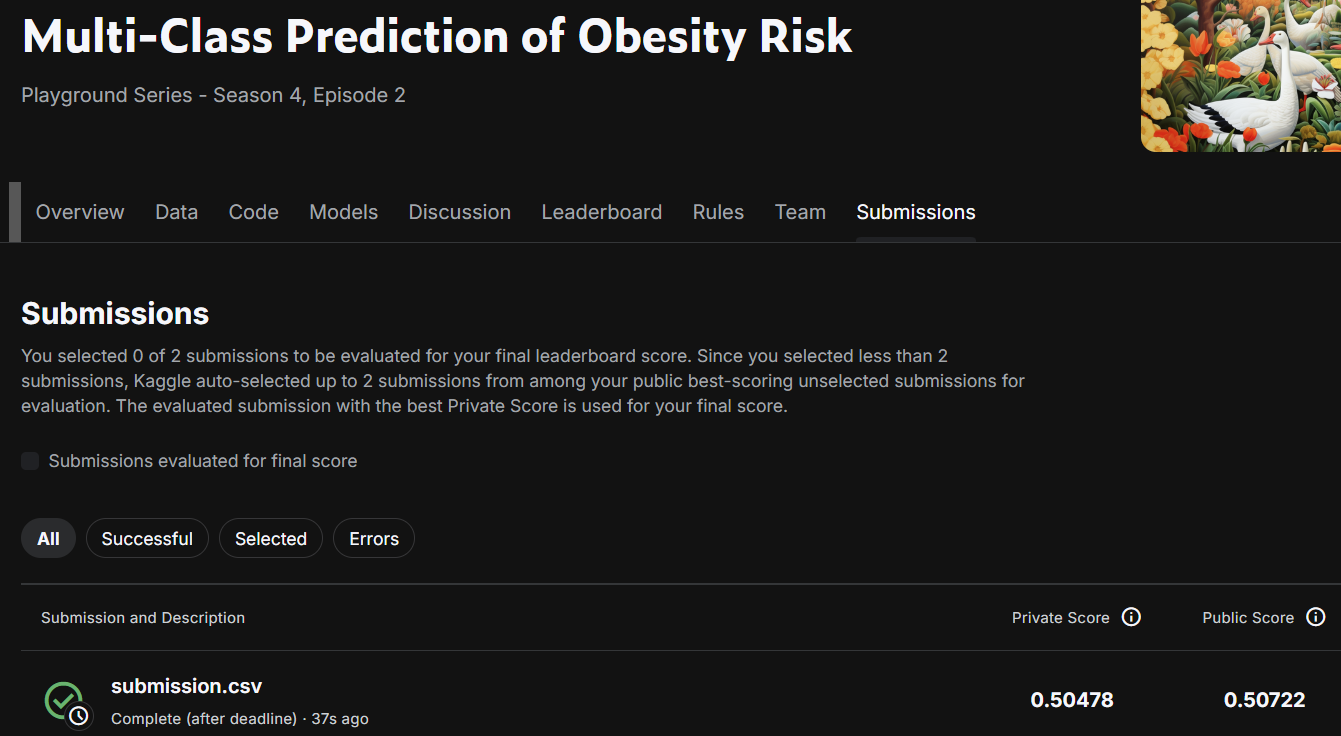

Our model score about 50% accuracy. This is not ideal, but it is definitely better than guessing (1/7). There are some takeaways and improvements to discuss. We used n_cluster=7 even though it was not optimal. We could have used n_cluster=18 based on the elbow method, but it would require a lot of effort to reassign the clusters to the proper obesity risk levels. This is something to be wary of and k-means cluster was possibly not the best choice. We could also improve the model by tuning more hyperparameters like tolerance or max_iter

References:
https://www.kaggle.com/competitions/playground-series-s4e2/overview
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
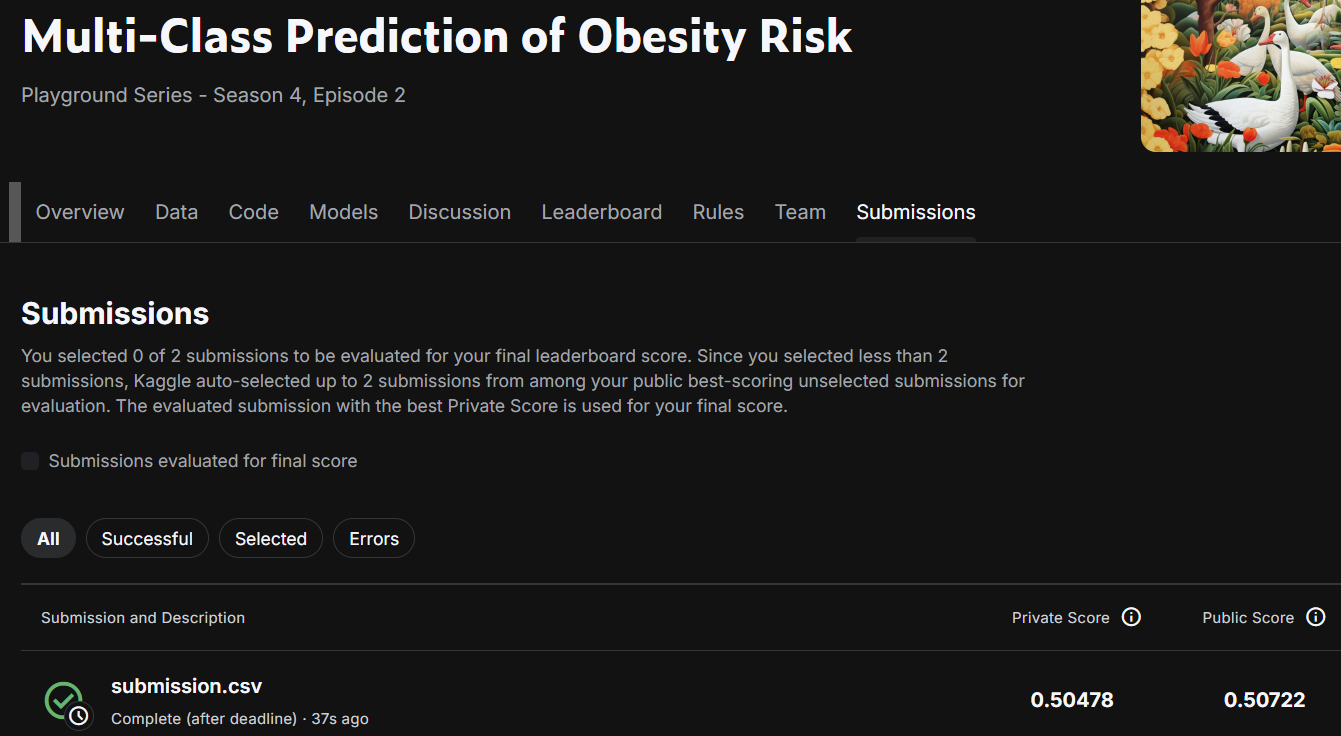